In [37]:
import csv
import itertools
from matplotlib import pyplot as plt
import numpy as np
import random

from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# import warnings
# warnings.filterwarnings("ignore")

### Read the data

Note about the data: The dataset is rather large, and very skewed toward valid transactions. To balance it a bit better, we sample and only keep around 5% of the valid transactions

In [2]:
with open('creditcard.csv', newline='') as f:
    reader = csv.reader(f, delimiter=',')
    csv_data = list(reader)[1:]
    
csv_data = [row for row in csv_data if int(row[-1]) == 1 or random.random() < .05]

# Format: Time, V1, ..., V28, Amount, Class
data = np.array([[float(x) for x in row[1:-1]] for row in csv_data])
times = np.array([float(row[0]) for row in csv_data])
labels = np.array([int(row[-1]) for row in csv_data])
print('The data is imbalanced, with {} samples in total but only {} cases of fraud'.format(len(labels), sum(labels)))

The data is imbalanced, with 14824 samples in total but only 492 cases of fraud


### Feature Scaling

In [3]:
print(np.mean(data, axis=0))
print(np.var(data, axis=0))
print('The PCA features have mean 0 but different variances')
print('The transaction amount is not scaled. We should scale it so it does not affect the SVM too much')

[-1.40101454e-01  1.10823645e-01 -2.45010890e-01  1.44844695e-01
 -6.75557110e-02 -4.87894568e-02 -1.74783737e-01  1.42450770e-02
 -7.60162559e-02 -1.94456613e-01  1.15786447e-01 -2.09944835e-01
  1.41180150e-02 -2.14943150e-01 -8.04210614e-03 -1.28941575e-01
 -2.03707060e-01 -7.02543582e-02  2.01613049e-02  3.79781959e-03
  2.20682274e-02  8.79503034e-04  6.62198597e-04 -5.39468397e-03
  8.10554930e-04  7.34338477e-03  3.64671315e-03  1.35676927e-03
  8.73907306e+01]
[5.88329475e+00 3.60655004e+00 5.31106452e+00 2.78979584e+00
 3.03478004e+00 1.90962596e+00 3.97317979e+00 2.99272338e+00
 1.54953277e+00 2.82881098e+00 1.67640956e+00 2.84929734e+00
 1.01359394e+00 2.98349251e+00 8.49833839e-01 1.71145200e+00
 3.58976523e+00 1.10460190e+00 7.51972870e-01 6.04158512e-01
 1.07553786e+00 5.84130260e-01 4.79947013e-01 3.65197144e-01
 2.87296137e-01 2.33583029e-01 2.13969056e-01 9.86701785e-02
 5.06785298e+04]
The PCA features have mean 0 but different variances
The transaction amount is not 

In [4]:
scaler = StandardScaler()
data_sc = scaler.fit_transform(data)
print(np.mean(data_sc, axis=0))
print(np.var(data_sc, axis=0))

[ 7.89453650e-17 -1.24817707e-16  5.22862319e-16 -7.43888371e-16
 -3.90929718e-16 -2.74530054e-16  9.65685827e-16  1.43982985e-16
 -6.66890240e-17 -9.19150676e-16 -1.67682322e-15  6.75914922e-18
 -8.88238335e-18  2.05230987e-16  1.34345112e-16  3.29962567e-17
 -4.61433636e-16  3.24296864e-16 -1.94049370e-17 -8.17651098e-17
 -5.36238320e-18  2.39959159e-17 -6.96810242e-17 -5.37286831e-17
 -8.73731440e-16  7.53055350e-18 -4.99989808e-17 -4.28915762e-17
  7.53663861e-15]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


### Preliminary plotting

[-1.00492934 -1.33088158  0.29850317 -2.37438031  1.17509409 -0.30631119
 -0.98663954 -2.41948563  0.09549002]


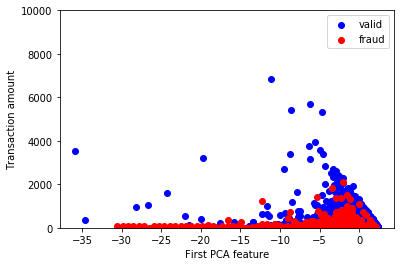

In [5]:
# plot the first two principal components
data_fraud = data[np.where(labels == 1)]
data_valid = data[np.where(labels == 0)]
plt.scatter(data_valid[:, 0], data_valid[:, -1], c='b')
plt.scatter(data_fraud[:, 0], data_fraud[:, -1], c='r')
print(data_valid[1:10, 0])
plt.ylim((0, 10000))
plt.legend(['valid', 'fraud'])
plt.xlabel('First PCA feature')
plt.ylabel('Transaction amount')
plt.show()

### Setting up cross-validation

In [6]:
fraud_indices = np.where(labels == 1)[0]
np.random.shuffle(fraud_indices)
fraud_splits = np.array_split(fraud_indices, 5)

valid_indices = np.where(labels == 0)[0]
np.random.shuffle(valid_indices)
valid_splits = np.array_split(valid_indices, 5)

folds = [np.concatenate((fraud_sp, valid_sp)) for fraud_sp, valid_sp in zip(fraud_splits, valid_splits)]

### SVM

In [7]:
def train_binary_SVM(data, scale=False, kernel=None, class_weight=None):
    confusion_mat = np.zeros((2, 2))
    for i in range(5):
        if kernel is None:
            if class_weight is None:
                svm = LinearSVC(fit_intercept=False, dual=False)
            else:
                svm = LinearSVC(fit_intercept=False, dual=False, class_weight=class_weight)
        else:
            if class_weight is None:
                svm = SVC(kernel=kernel, gamma='auto')
            else:
                svm = SVC(kernel=kernel, gamma='auto', class_weight=class_weight)
        
        train_data = np.delete(data, folds[i], axis=0)
        test_data = data[folds[i]]
        if scale:
            scaler = StandardScaler()
            train_data = scaler.fit_transform(train_data)
            test_data = scaler.transform(test_data)

        svm.fit(train_data, np.delete(labels, folds[i]))
        pred = svm.predict(test_data)

        conf_mat = confusion_matrix(labels[folds[i]], pred)
        print('Fold', i)
        print(conf_mat)

        confusion_mat += conf_mat

    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    print('False negatives (valid):', confusion_mat[0, 1] / sum(confusion_mat[0, :]))
    print('False positives (fraud):', confusion_mat[1, 0] / sum(confusion_mat[1,:]))
    return confusion_mat

#### Linear SVM -- Without scaling or class weights

In [8]:
train_binary_SVM(data);

Fold 0
[[2853   14]
 [  23   76]]
Fold 1
[[2855   12]
 [  31   68]]
Fold 2
[[2859    7]
 [  21   77]]
Fold 3
[[2854   12]
 [  18   80]]
Fold 4
[[2853   13]
 [  17   81]]
Final Confusion Matrix
[[2854.8   11.6]
 [  22.    76.4]]
False negatives (valid): 0.004046888082612336
False positives (fraud): 0.22357723577235772


#### Linear SVM with Scaling

In [9]:
train_binary_SVM(data, scale=True);

Fold 0
[[2864    3]
 [  18   81]]
Fold 1
[[2865    2]
 [  24   75]]
Fold 2
[[2865    1]
 [  18   80]]
Fold 3
[[2863    3]
 [  18   80]]
Fold 4
[[2861    5]
 [  13   85]]
Final Confusion Matrix
[[2.8636e+03 2.8000e+00]
 [1.8200e+01 8.0200e+01]]
False negatives (valid): 0.0009768350544236673
False positives (fraud): 0.18495934959349591


#### Linear SVM with Scaling and Class Weights

In [10]:
train_binary_SVM(data, scale=True, class_weight='balanced');

Fold 0
[[2778   89]
 [   5   94]]
Fold 1
[[2786   81]
 [  12   87]]
Fold 2
[[2758  108]
 [  12   86]]
Fold 3
[[2787   79]
 [   6   92]]
Fold 4
[[2745  121]
 [   7   91]]
Final Confusion Matrix
[[2770.8   95.6]
 [   8.4   90. ]]
False negatives (valid): 0.033351939715322354
False positives (fraud): 0.08536585365853658


### Kernel SVM

#### RBF Kernel with Scaling and Class Weights

In [11]:
train_binary_SVM(data, scale=True, kernel='rbf');

Fold 0
[[2866    1]
 [  22   77]]
Fold 1
[[2866    1]
 [  29   70]]
Fold 2
[[2866    0]
 [  25   73]]
Fold 3
[[2865    1]
 [  19   79]]
Fold 4
[[2865    1]
 [  18   80]]
Final Confusion Matrix
[[2.8656e+03 8.0000e-01]
 [2.2600e+01 7.5800e+01]]
False negatives (valid): 0.00027909572983533354
False positives (fraud): 0.22967479674796748


In [12]:
train_binary_SVM(data, kernel='rbf', class_weight='balanced');

Fold 0
[[2852   15]
 [  46   53]]
Fold 1
[[2859    8]
 [  44   55]]
Fold 2
[[2858    8]
 [  59   39]]
Fold 3
[[2855   11]
 [  43   55]]
Fold 4
[[2852   14]
 [  43   55]]
Final Confusion Matrix
[[2855.2   11.2]
 [  47.    51.4]]
False negatives (valid): 0.003907340217694669
False positives (fraud): 0.4776422764227642


#### Polynomial Kernel with Scaling and Class Weights

In [13]:
train_binary_SVM(data, scale=True, kernel='poly');

Fold 0
[[2865    2]
 [  17   82]]
Fold 1
[[2866    1]
 [  25   74]]
Fold 2
[[2864    2]
 [  19   79]]
Fold 3
[[2864    2]
 [  18   80]]
Fold 4
[[2858    8]
 [  14   84]]
Final Confusion Matrix
[[2863.4    3. ]
 [  18.6   79.8]]
False negatives (valid): 0.0010466089868825007
False positives (fraud): 0.18902439024390244


In [14]:
train_binary_SVM(data, scale=True, kernel='poly', class_weight='balanced');

Fold 0
[[2843   24]
 [  11   88]]
Fold 1
[[2859    8]
 [  17   82]]
Fold 2
[[2843   23]
 [  18   80]]
Fold 3
[[2845   21]
 [  13   85]]
Fold 4
[[2848   18]
 [  14   84]]
Final Confusion Matrix
[[2847.6   18.8]
 [  14.6   83.8]]
False negatives (valid): 0.006558749651130338
False positives (fraud): 0.1483739837398374


### Logistic Regression

In [15]:
def train_logistic_regression(data, class_weight = None, C=1.0):
    err = 0
    err_valid = 0
    err_fraud = 0
    confusion_mat = np.zeros((2, 2))
    AU = 0
    for i in range(5):
        model = LogisticRegression(class_weight=class_weight, C=C)
        
        model.fit(np.delete(data, folds[i], axis=0), np.delete(labels, folds[i]))
        pred = model.predict(data[folds[i]])
        pred1 = model.predict_proba(data[folds[i]])[:,1]
        #err_fold = np.sum((pred - labels[folds[i]])**2) / len(folds[i])
        #pred_valid = model.predict(data[valid_splits[i]])
        #err_valid_fold = np.sum((pred_valid - labels[valid_splits[i]])**2) / len(valid_splits[i])
        #pred_fraud = model.predict(data[fraud_splits[i]])
        #err_fraud_fold = np.sum((pred_fraud - labels[fraud_splits[i]])**2) / len(fraud_splits[i])
        #print('Fold', i, 'Error:', err_fold, 'Valid Error:', err_valid_fold, 'Fraud Error', err_fraud_fold)
        #err += err_fold
        #err_valid += err_valid_fold
        #err_fraud += err_fraud_fold
        conf_mat = confusion_matrix(labels[folds[i]], pred)
        fpr, tpr, thresholds = roc_curve(labels[folds[i]], pred1)
        area_under_curve = auc(fpr, tpr)
        AU += area_under_curve
        print('Fold', i)
        print(conf_mat)
        print('Area under curve:', area_under_curve)

        confusion_mat += conf_mat
    AU/=5
    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    return confusion_mat, AU
    #err /= 5
    #err_valid /= 5
    #err_fraud /= 5
    #print('FINAL Error:', err, 'Valid Error:', err_valid, 'Fraud Error', err_fraud)
    #return err, err_valid, err_fraud

#### Logistic Regression with Scaling, Class Weights, and Regularization

In [16]:
weights = [None,'balanced']
coefficients = np.logspace(-2,0,10)
fscore = []
recall = []
precision = []
AU = []
param_permuations = list(itertools.product(weights, coefficients))
for cw,C in param_permuations:
    print('Checking class weight {} and coefficient {}'.format(cw, C))
    cf,au = train_logistic_regression(data_sc, cw, C)
    TP = cf[1][1]
    FP = cf[0][1]
    FN = cf[1][0]
    prec = TP/(TP+FP)
    rec = TP/(TP+FN)
    f1 = prec*rec*2/(prec+rec)
    print('F1 score:', f1)
    print('Recall:', rec)
    print('Precision:', prec)
    print('AUC:', au)
    fscore.append(f1)
    recall.append(rec)
    precision.append(prec)
    AU.append(au)

idx = np.argmax(AU)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under AUC metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(f1)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under F1 metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(precision)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under precision metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(recall)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under recall metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

Checking class weight None and coefficient 0.01
Fold 0
[[2865    2]
 [  18   81]]
Area under curve: 0.9847163649047153
Fold 1
[[2866    1]
 [  24   75]]
Area under curve: 0.9787621594388249
Fold 2
[[2866    0]
 [  18   80]]
Area under curve: 0.978534400501303
Fold 3
[[2863    3]
 [  17   81]]
Area under curve: 0.9787052992864975


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4
[[2865    1]
 [  13   85]]
Area under curve: 0.9818704872039534
Final Confusion Matrix
[[2.865e+03 1.400e+00]
 [1.800e+01 8.040e+01]]
F1 score: 0.8923418423973364
Recall: 0.8170731707317074
Precision: 0.9828850855745721
AUC: 0.9805177422670589
Checking class weight None and coefficient 0.016681005372000592
Fold 0
[[2865    2]
 [  18   81]]
Area under curve: 0.9850017439832579
Fold 1
[[2866    1]
 [  24   75]]
Area under curve: 0.9790087833338619
Fold 2
[[2866    0]
 [  18   80]]
Area under curve: 0.9786483330247661


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

Fold 3
[[2863    3]
 [  16   82]]
Area under curve: 0.9800902915248443
Fold 4
[[2865    1]
 [  13   85]]
Area under curve: 0.9824543913867011
Final Confusion Matrix
[[2.865e+03 1.400e+00]
 [1.780e+01 8.060e+01]]
F1 score: 0.893569844789357
Recall: 0.8191056910569106
Precision: 0.9829268292682927
AUC: 0.9810407086506864
Checking class weight None and coefficient 0.027825594022071243
Fold 0
[[2865    2]
 [  17   82]]
Area under curve: 0.9851180095337752
Fold 1
[[2866    1]
 [  24   75]]
Area under curve: 0.9790616313113697
Fold 2
[[2866    0]
 [  18   80]]
Area under curve: 0.9782424484099291


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

Fold 3
[[2863    3]
 [  16   82]]
Area under curve: 0.981407636327385
Fold 4
[[2865    1]
 [  13   85]]
Area under curve: 0.9831273053534044
Final Confusion Matrix
[[2.865e+03 1.400e+00]
 [1.760e+01 8.080e+01]]
F1 score: 0.8947951273532667
Recall: 0.8211382113821137
Precision: 0.9829683698296836
AUC: 0.9813914061871728
Checking class weight None and coefficient 0.046415888336127774
Fold 0
[[2865    2]
 [  16   83]]
Area under curve: 0.9850616383577668
Fold 1
[[2866    1]
 [  24   75]]
Area under curve: 0.978970028150356
Fold 2
[[2866    0]
 [  18   80]]
Area under curve: 0.9774662830938377


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

Fold 3
[[2863    3]
 [  15   83]]
Area under curve: 0.982468632952134
Fold 4
[[2865    1]
 [  13   85]]
Area under curve: 0.9840280843670335
Final Confusion Matrix
[[2.865e+03 1.400e+00]
 [1.720e+01 8.120e+01]]
F1 score: 0.8972375690607735
Recall: 0.8252032520325203
Precision: 0.983050847457627
AUC: 0.9815989333842257
Checking class weight None and coefficient 0.0774263682681127
Fold 0
[[2865    2]
 [  17   82]]
Area under curve: 0.985036975968263
Fold 1
[[2866    1]
 [  24   75]]
Area under curve: 0.9786952186673149
Fold 2
[[2865    1]
 [  18   80]]
Area under curve: 0.9761881025962375


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

Fold 3
[[2863    3]
 [  15   83]]
Area under curve: 0.9834228178361366
Fold 4
[[2864    2]
 [  13   85]]
Area under curve: 0.9847900081176922
Final Confusion Matrix
[[2.8646e+03 1.8000e+00]
 [1.7400e+01 8.1000e+01]]
F1 score: 0.8940397350993378
Recall: 0.823170731707317
Precision: 0.9782608695652174
AUC: 0.9816266246371288
Checking class weight None and coefficient 0.1291549665014884
Fold 0
[[2865    2]
 [  17   82]]
Area under curve: 0.9849488960057499


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1
[[2866    1]
 [  24   75]]
Area under curve: 0.977645305514158
Fold 2
[[2865    1]
 [  18   80]]
Area under curve: 0.9748031103578906
Fold 3
[[2863    3]
 [  14   84]]
Area under curve: 0.9842595098053177
Fold 4
[[2863    3]
 [  13   85]]
Area under curve: 0.9854095162140223
Final Confusion Matrix
[[2.8644e+03 2.0000e+00]
 [1.7200e+01 8.1200e+01]]
F1 score: 0.894273127753304
Recall: 0.8252032520325203
Precision: 0.9759615384615384
AUC: 0.9814132675794276
Checking class weight None and coefficient 0.21544346900318834


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0
[[2865    2]
 [  17   82]]
Area under curve: 0.9847234113017161
Fold 1
[[2866    1]
 [  24   75]]
Area under curve: 0.9764967428029863
Fold 2
[[2864    2]
 [  17   81]]
Area under curve: 0.9731760115071848


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3
[[2862    4]
 [  14   84]]
Area under curve: 0.9845265391571841
Fold 4
[[2863    3]
 [  13   85]]
Area under curve: 0.9858972898300982
Final Confusion Matrix
[[2.864e+03 2.400e+00]
 [1.700e+01 8.140e+01]]
F1 score: 0.8935236004390779
Recall: 0.8272357723577236
Precision: 0.9713603818615751
AUC: 0.9809639989198338
Checking class weight None and coefficient 0.3593813663804626
Fold 0
[[2865    2]
 [  17   82]]
Area under curve: 0.9844697410096782


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1
[[2866    1]
 [  24   75]]
Area under curve: 0.9753657960843171
Fold 2
[[2864    2]
 [  17   81]]
Area under curve: 0.9717732173120469
Fold 3
[[2861    5]
 [  14   84]]
Area under curve: 0.9844980560263185


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4
[[2862    4]
 [  13   85]]
Area under curve: 0.9862497685745617
Final Confusion Matrix
[[2.8636e+03 2.8000e+00]
 [1.7000e+01 8.1400e+01]]
F1 score: 0.8915662650602411
Recall: 0.8272357723577236
Precision: 0.9667458432304038
AUC: 0.9804713158013845
Checking class weight None and coefficient 0.5994842503189409
Fold 0
[[2865    2]
 [  17   82]]
Area under curve: 0.984113897961125
Fold 1
[[2866    1]
 [  24   75]]
Area under curve: 0.9742841741446555


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2
[[2864    2]
 [  17   81]]
Area under curve: 0.9706267712947008
Fold 3
[[2861    5]
 [  13   85]]
Area under curve: 0.9844054858510046
Fold 4
[[2862    4]
 [  13   85]]
Area under curve: 0.9865381602745773
Final Confusion Matrix
[[2.8636e+03 2.8000e+00]
 [1.6800e+01 8.1600e+01]]
F1 score: 0.8927789934354485
Recall: 0.8292682926829268
Precision: 0.966824644549763
AUC: 0.9799936979052125
Checking class weight None and coefficient 1.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0
[[2865    2]
 [  17   82]]
Area under curve: 0.9837968100960776
Fold 1
[[2866    1]
 [  24   75]]
Area under curve: 0.973304724961509
Fold 2
[[2864    2]
 [  17   81]]
Area under curve: 0.9698185624563852


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3
[[2861    5]
 [  13   85]]
Area under curve: 0.9843413988065568
Fold 4
[[2862    4]
 [  13   85]]
Area under curve: 0.9867980688437273
Final Confusion Matrix
[[2.8636e+03 2.8000e+00]
 [1.6800e+01 8.1600e+01]]
F1 score: 0.8927789934354485
Recall: 0.8292682926829268
Precision: 0.966824644549763
AUC: 0.9796119130328511
Checking class weight balanced and coefficient 0.01
Fold 0
[[2798   69]
 [   6   93]]
Area under curve: 0.9839624004256023


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1
[[2827   40]
 [  14   85]]
Area under curve: 0.9769089570275479
Fold 2
[[2809   57]
 [  15   83]]
Area under curve: 0.9668207129327656
Fold 3
[[2817   49]
 [   7   91]]
Area under curve: 0.983088141048464
Fold 4
[[2795   71]
 [   9   89]]
Area under curve: 0.9867268610165629
Final Confusion Matrix
[[2809.2   57.2]
 [  10.2   88.2]]
F1 score: 0.7235438884331419
Recall: 0.8963414634146342
Precision: 0.6066024759284732
AUC: 0.9795014144901885
Checking class weight balanced and coefficient 0.016681005372000592


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0
[[2796   71]
 [   5   94]]
Area under curve: 0.984039910792614
Fold 1
[[2825   42]
 [  13   86]]
Area under curve: 0.976475603611983
Fold 2
[[2806   60]
 [  15   83]]
Area under curve: 0.9654357206944186
Fold 3

/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



[[2815   51]
 [   7   91]]
Area under curve: 0.9834014554879873
Fold 4
[[2792   74]
 [   9   89]]
Area under curve: 0.9870437358474443
Final Confusion Matrix
[[2806.8   59.6]
 [   9.8   88.6]]
F1 score: 0.7185725871857258
Recall: 0.9004065040650406
Precision: 0.5978407557354926
AUC: 0.9792792852868895
Checking class weight balanced and coefficient 0.027825594022071243
Fold 0
[[2793   74]
 [   5   94]]
Area under curve: 0.9840575267851165


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1
[[2824   43]
 [  13   86]]
Area under curve: 0.9758097190953835
Fold 2
[[2806   60]
 [  15   83]]
Area under curve: 0.9639367959326088
Fold 3
[[2813   53]
 [   7   91]]
Area under curve: 0.9835972770126893


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4
[[2787   79]
 [   9   89]]
Area under curve: 0.9873677314610423
Final Confusion Matrix
[[2804.6   61.8]
 [   9.8   88.6]]
F1 score: 0.7122186495176849
Recall: 0.9004065040650406
Precision: 0.5890957446808511
AUC: 0.9789538100573681
Checking class weight balanced and coefficient 0.046415888336127774
Fold 0
[[2793   74]
 [   5   94]]
Area under curve: 0.9840610499836172
Fold 1
[[2822   45]
 [  13   86]]
Area under curve: 0.9751755433652888


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2
[[2807   59]
 [  15   83]]
Area under curve: 0.9625411225201874
Fold 3
[[2810   56]
 [   7   91]]
Area under curve: 0.9837183303188686
Fold 4
[[2787   79]
 [   9   89]]
Area under curve: 0.9876668043351325
Final Confusion Matrix
[[2803.8   62.6]
 [   9.8   88.6]]
F1 score: 0.7099358974358975
Recall: 0.9004065040650406
Precision: 0.5859788359788359
AUC: 0.978632570104619
Checking class weight balanced and coefficient 0.0774263682681127


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0
[[2791   76]
 [   5   94]]
Area under curve: 0.9841526531446307
Fold 1
[[2822   45]
 [  13   86]]
Area under curve: 0.9746188780022056
Fold 2
[[2805   61]
 [  15   83]]
Area under curve: 0.9614587635472891


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3
[[2811   55]
 [   7   91]]
Area under curve: 0.9838358232336899
Fold 4
[[2784   82]
 [   9   89]]
Area under curve: 0.9879409544697153
Final Confusion Matrix
[[2802.6   63.8]
 [   9.8   88.6]]
F1 score: 0.7065390749601276
Recall: 0.9004065040650406
Precision: 0.5813648293963255
AUC: 0.9784014144795062
Checking class weight balanced and coefficient 0.1291549665014884
Fold 0
[[2789   78]
 [   5   94]]
Area under curve: 0.9842160707176403


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1
[[2821   46]
 [  13   86]]
Area under curve: 0.9741502926016355
Fold 2
[[2804   62]
 [  15   83]]
Area under curve: 0.9605223806200778
Fold 3
[[2812   54]
 [   7   91]]
Area under curve: 0.9839604369312274


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4
[[2781   85]
 [   9   89]]
Area under curve: 0.9881581383425666
Final Confusion Matrix
[[2801.4   65. ]
 [   9.8   88.6]]
F1 score: 0.7031746031746032
Recall: 0.9004065040650406
Precision: 0.5768229166666666
AUC: 0.9782014638426295
Checking class weight balanced and coefficient 0.21544346900318834
Fold 0
[[2788   79]
 [   5   94]]
Area under curve: 0.9842777266913996
Fold 1
[[2818   49]
 [  13   86]]
Area under curve: 0.9738966223095976


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2
[[2805   61]
 [  15   83]]
Area under curve: 0.9595824373015083
Fold 3
[[2811   55]
 [   7   91]]
Area under curve: 0.9841064129769144
Fold 4
[[2779   87]
 [   8   90]]
Area under curve: 0.9883753222154179
Final Confusion Matrix
[[2800.2   66.2]
 [   9.6   88.8]]
F1 score: 0.7008681925808997
Recall: 0.9024390243902439
Precision: 0.5729032258064516
AUC: 0.9780477042989677
Checking class weight balanced and coefficient 0.3593813663804626


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0
[[2789   78]
 [   5   94]]
Area under curve: 0.9843323362681576
Fold 1
[[2817   50]
 [  13   86]]
Area under curve: 0.9737521711710759
Fold 2
[[2806   60]
 [  15   83]]
Area under curve: 0.9588205135508495


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3
[[2811   55]
 [   7   91]]
Area under curve: 0.9842452682398849
Fold 4
[[2781   85]
 [   8   90]]
Area under curve: 0.9885212982611048
Final Confusion Matrix
[[2800.8   65.6]
 [   9.6   88.8]]
F1 score: 0.7025316455696203
Recall: 0.9024390243902439
Precision: 0.5751295336787565
AUC: 0.9779343174982147
Checking class weight balanced and coefficient 0.5994842503189409
Fold 0
[[2789   78]
 [   5   94]]
Area under curve: 0.9844662178111777


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1
[[2818   49]
 [  13   86]]
Area under curve: 0.9737345551785733
Fold 2
[[2806   60]
 [  15   83]]
Area under curve: 0.9583434211088483
Fold 3
[[2813   53]
 [   7   91]]
Area under curve: 0.9843787829158182


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4
[[2781   85]
 [   8   90]]
Area under curve: 0.9885960664796274
Final Confusion Matrix
[[2801.4   65. ]
 [   9.6   88.8]]
F1 score: 0.704203013481364
Recall: 0.9024390243902439
Precision: 0.577373211963589
AUC: 0.977903808698809
Checking class weight balanced and coefficient 1.0
Fold 0
[[2789   78]
 [   5   94]]
Area under curve: 0.9845190657886856


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1
[[2818   49]
 [  13   86]]
Area under curve: 0.9736640912085628
Fold 2
[[2806   60]
 [  15   83]]
Area under curve: 0.9579375364940114
Fold 3
[[2813   53]
 [   7   91]]
Area under curve: 0.9844802540695273


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4
[[2781   85]
 [   8   90]]
Area under curve: 0.9886708346981501
Final Confusion Matrix
[[2801.4   65. ]
 [   9.6   88.8]]
F1 score: 0.704203013481364
Recall: 0.9024390243902439
Precision: 0.577373211963589
AUC: 0.9778543564517875
Best parameters found for Logistic Regression under AUC metric is None class weights and 0.0774263682681127 coefficient
Best parameters found for Logistic Regression under F1 metric is None class weights and 0.01 coefficient
Best parameters found for Logistic Regression under precision metric is None class weights and 0.046415888336127774 coefficient
Best parameters found for Logistic Regression under recall metric is balanced class weights and 0.21544346900318834 coefficient


# kNN

In [41]:
def train_KNN(data, k, scale=False):
    confusion_mat = np.zeros((2, 2))
    AU = 0
    for i in range(5):
        knn = KNeighborsClassifier(n_neighbors=k)
        
        train_data = np.delete(data, folds[i], axis=0)
        test_data = data[folds[i]]
        if scale:
            scaler = StandardScaler()
            train_data = scaler.fit_transform(train_data)
            test_data = scaler.transform(test_data)

        knn.fit(train_data, np.delete(labels, folds[i]))
        pred = knn.predict(test_data)

        conf_mat = confusion_matrix(labels[folds[i]], pred)
#         print('Fold', i)
#         print(conf_mat)
        fpr, tpr, thresholds = roc_curve(labels[folds[i]], pred)
        area_under_curve = auc(fpr, tpr)
        AU += area_under_curve
#         print('Fold', i)
#         print(conf_mat)
#         print('Area under curve:', area_under_curve)

        confusion_mat += conf_mat

    confusion_mat /= 5
    AU /= 5
#     print('Final Confusion Matrix')
#     print(confusion_mat)
    
#     fnr = confusion_mat[0, 1] / sum(confusion_mat[0, :])
#     fpr = confusion_mat[1, 0] / sum(confusion_mat[1,:])
#     print('False negatives (valid):', fnr)
#     print('False positives (fraud):', fpr)
    
#     metric = (fnr * (len(labels) - sum(labels)) + fpr * sum(labels)) / len(labels)
    return confusion_mat, AU

In [43]:
for k in [1, 3, 5, 7, 9, 11]:
    print('K = {}'.format(k))
    conf, au = train_KNN(data, k)
    print('Confusion Matrix:')
    print(conf)
#     print('AUC: {}'.format(au))
#     print('recall: {}'.format(conf[1, 0] / sum(conf[:, 0])))
    fnr = conf[0, 1] / sum(conf[0, :])
    fpr = conf[1, 0] / sum(conf[1,:])
    metric = (fnr * (len(labels) - sum(labels)) + fpr * sum(labels)) / len(labels)
    print('metric: {}'.format(metric))
    fscore = 2*conf[0,0] / (2*conf[0,0] + conf[0,1] + conf[1,0])
    print('fscore: {}'.format(fscore))
    print()

K = 1
Confusion Matrix:
[[2855.8   10.6]
 [  21.6   76.8]]
metric: 0.010860766324878575
fscore: 0.9943939552212819

K = 3
Confusion Matrix:
[[2.8642e+03 2.2000e+00]
 [2.4800e+01 7.3600e+01]]
metric: 0.009106853750674583
fscore: 0.9953087535184348

K = 5
Confusion Matrix:
[[2.8642e+03 2.2000e+00]
 [2.7400e+01 7.1000e+01]]
metric: 0.009983810037776578
fscore: 0.994859326154915

K = 7
Confusion Matrix:
[[2.8646e+03 1.8000e+00]
 [3.0000e+01 6.8400e+01]]
metric: 0.010725849973016729
fscore: 0.9944801249783023

K = 9
Confusion Matrix:
[[2.8646e+03 1.8000e+00]
 [3.4000e+01 6.4400e+01]]
metric: 0.012075013491635186
fscore: 0.9937901127493495

K = 11
Confusion Matrix:
[[2.8646e+03 1.8000e+00]
 [3.5800e+01 6.2600e+01]]
metric: 0.01268213707501349
fscore: 0.9934799195394326

